In [ ]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle,Circle

from quantum import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\usepackage{times}\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif') #plt.rc('font', **{'serif': ['Times']})

## Set up system

In [4]:
s = 1/2
M = int(2*s+1)

N = 16
n = M**N

N_S = 2
N_B = N - N_S

S_idx = [0,1]
B_idx = np.setdiff1d(np.arange(N),S_idx)

In [18]:
J = 1
hs = np.linspace(0,2.5,501)
                
θs = np.arctan(1/hs)
α = 1,
βs = 1/np.logspace(-2.5,2,100)


<ipython-input-18-e7d201059ed9>:4: RuntimeWarning: divide by zero encountered in true_divide
  θs = np.arctan(1/hs)


In [19]:
n_ave = 400
k = 60

EVs = np.zeros((len(θs),len(βs),M**N_S))
GSEVs = np.zeros((len(θs),M**N_S))

In [20]:
idxs = []
for q in range(501):
    try:
        EVs[q],GSEVs[q],_,_ = np.load(f'data/EVs_{N}_{k}_{n_ave}_{q}.npy',allow_pickle=True)
        idxs.append(q)
    except:
        pass
    

In [21]:
ρ_mfs = EVs/np.sum(EVs,axis=-1)[:,:,None]
vNEntropy = -np.sum(sp.special.xlogy(ρ_mfs,np.abs(ρ_mfs)),axis=-1)

ρGS_mfs = GSEVs/np.sum(GSEVs,axis=-1)[:,None]
vNEntropy_GS = -np.sum(sp.special.xlogy(ρGS_mfs,np.abs(ρGS_mfs)),axis=-1)

<ipython-input-21-9be36a0ee48d>:1: RuntimeWarning: invalid value encountered in true_divide
  ρ_mfs = EVs/np.sum(EVs,axis=-1)[:,:,None]
<ipython-input-21-9be36a0ee48d>:4: RuntimeWarning: invalid value encountered in true_divide
  ρGS_mfs = GSEVs/np.sum(GSEVs,axis=-1)[:,None]


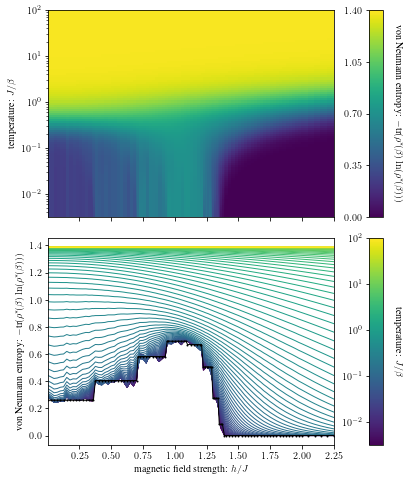

In [26]:
fig,axs = plt.subplots(2,3,figsize=(6,8),gridspec_kw={'width_ratios': [1,.05,.05]})
fig.subplots_adjust(wspace=.1,hspace=0.1)

#axs[0].set_title(f'$\\alpha$={αs[i]}')
cm = axs[0,0].pcolormesh(np.cos(θs[idxs])/np.sin(θs[idxs]),1/βs,vNEntropy[idxs,:].T,vmin=0,vmax=1.4,rasterized=True)

cbar= plt.colorbar(cm,ticks=np.linspace(0,1.4,5),cax=axs[0,2])
cbar.ax.yaxis.set_ticks_position('left')

axs[0,0].set_yscale('log')
axs[0,0].set_ylabel('temperature: $J/\\beta$')
axs[0,1].set_axis_off()
axs[0,2].set_ylabel('von Neumann entropy: $-\\textrm{tr}(\\rho^*\!(\\beta)\ln(\\rho^*\!(\\beta)))$',rotation=-90, labelpad=20)


axs[0,0].set_xticklabels([])
axs[1,0].get_shared_x_axes().join(axs[0,0], axs[1,0])

βs_to_int = lambda β: (np.log10(βs[0]) - np.log10(β)) / (np.log10(βs[0])-np.log10(βs[-1]))
#axs[1,0].set_prop_cycle('color',[plt.cm.viridis(_) for _ in np.linspace(0, 1, len(βs))])
for l,β in enumerate(βs):
    axs[1,0].plot(np.cos(θs[idxs])/np.sin(θs[idxs]),vNEntropy[idxs,l],lw=1,color=plt.cm.viridis(βs_to_int(β)))

axs[1,0].plot(np.cos(θs[idxs])/np.sin(θs[idxs]),vNEntropy_GS[idxs],lw=1,marker='.',ms=2,color='k')


cmap = plt.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])

Ts = np.array([1e-2,1e-1,1e0,1e1,1e2])
cbar = plt.colorbar(sm,ticks=βs_to_int(1/Ts),cax=axs[1,2])

#cbar.ax.set_yticklabels([np.format_float_scientific(T,exp_digits=1) for T in Ts]);  # vertically oriented colorbar
cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(T))}}}$' for T in Ts]);  # vertically oriented colorbar
cbar.ax.yaxis.set_ticks_position('left')
axs[1,2].set_ylabel('temperature: $J/\\beta$',rotation=-90, labelpad=20)

axs[1,0].set_xlabel('magnetic field strength: $h/J$')
axs[1,0].set_ylabel('von Neumann entropy: $-\\textrm{tr}(\\rho^*\!(\\beta)\ln(\\rho^*\!(\\beta)))$')
axs[1,1].set_axis_off()
#axs[1,3].text(1,.5,'temperature',rotation=-90,horizontalalignment='center',verticalalignment='center', transform=axs[1,2].transAxes)

if False:
    axs[1,0].axvline(hs[70])
    axs[1,0].axvline(hs[75])

    axs[1,0].axvline(hs[140])
    axs[1,0].axvline(hs[145])

    axs[1,0].axvline(hs[185])
    axs[1,0].axvline(hs[190])

    axs[1,0].axvline(hs[215])
    axs[1,0].axvline(hs[220])

    axs[1,0].axvline(hs[240])
    axs[1,0].axvline(hs[280])

plt.savefig('spin_imgs/vNEntropy.pdf',bbox_inches='tight')

# Exact density

In [13]:
def get_density_EVs(h,J,β,N):
    
    k = np.arange(N)+1

    λk = h - 2*J*np.cos(k*np.pi/(N+1))
    Nk = 1/(1+np.exp(β*λk))

    σ1xσ2x = -4/(N+1)*np.sum(np.sin(k*np.pi/(N+1))*np.sin(2*k*np.pi/(N+1))*Nk)
    σ1z = -1+4/(N+1)*np.sum(np.sin(k*np.pi/(N+1))**2*Nk)
    σ2z = -1+4/(N+1)*np.sum(np.sin(2*k*np.pi/(N+1))**2*Nk)
    σ1zσ2z = σ1z*σ2z-σ1xσ2x**2

    δ = np.sqrt(4*σ1xσ2x**2+(σ1z-σ2z)**2)
    p1 = (1 + σ1z + σ2z + σ1zσ2z)/4
    p2 = (1 - δ - σ1zσ2z)/4
    p3 = (1 + δ - σ1zσ2z)/4
    p4 = (1 - σ1z - σ2z + σ1zσ2z)/4
    
    return np.array([p1,p2,p3,p4])

In [27]:
n_pts = 1000

J = 1
hs = np.linspace(0,2.5,n_pts)

density_EVs = np.zeros((n_pts,len(βs),4))
for l,β in enumerate(βs):
    for i in range(n_pts):
        density_EVs[i,l] = get_density_EVs(hs[i],J,β,16)
        
vNEntropy = -np.sum(sp.special.xlogy(density_EVs,np.abs(density_EVs)),axis=-1)

<ipython-input-13-b712543feebe>:6: RuntimeWarning: overflow encountered in exp
  Nk = 1/(1+np.exp(β*λk))


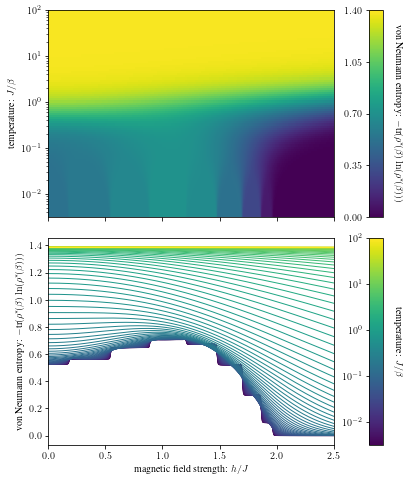

In [28]:
fig,axs = plt.subplots(2,3,figsize=(6,8),gridspec_kw={'width_ratios': [1,.05,.05]})
fig.subplots_adjust(wspace=.1,hspace=0.1)

#axs[0].set_title(f'$\\alpha$={αs[i]}')
cm = axs[0,0].pcolormesh(hs,1/βs,vNEntropy[:,:].T,vmin=0,vmax=1.4,rasterized=True)

cbar= plt.colorbar(cm,ticks=np.linspace(0,1.4,5),cax=axs[0,2])
cbar.ax.yaxis.set_ticks_position('left')

axs[0,0].set_yscale('log')
axs[0,0].set_ylabel('temperature: $J/\\beta$')
axs[0,1].set_axis_off()
axs[0,2].set_ylabel('von Neumann entropy: $-\\textrm{tr}(\\rho^*\!(\\beta)\ln(\\rho^*\!(\\beta)))$',rotation=-90, labelpad=20)


axs[0,0].set_xticklabels([])
axs[1,0].get_shared_x_axes().join(axs[0,0], axs[1,0])

βs_to_int = lambda β: (np.log10(βs[0]) - np.log10(β)) / (np.log10(βs[0])-np.log10(βs[-1]))
#axs[1,0].set_prop_cycle('color',[plt.cm.viridis(_) for _ in np.linspace(0, 1, len(βs))])
for l,β in enumerate(βs):
    axs[1,0].plot(hs,vNEntropy[:,l],lw=1,color=plt.cm.viridis(βs_to_int(β)))

#axs[1,0].plot(hs,vNEntropy_GS,lw=1,marker='.',ms=2,color='k')


cmap = plt.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])

Ts = np.array([1e-2,1e-1,1e0,1e1,1e2])
cbar = plt.colorbar(sm,ticks=βs_to_int(1/Ts),cax=axs[1,2])

#cbar.ax.set_yticklabels([np.format_float_scientific(T,exp_digits=1) for T in Ts]);  # vertically oriented colorbar
cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(T))}}}$' for T in Ts]);  # vertically oriented colorbar
cbar.ax.yaxis.set_ticks_position('left')
axs[1,2].set_ylabel('temperature: $J/\\beta$',rotation=-90, labelpad=20)

axs[1,0].set_xlabel('magnetic field strength: $h/J$')
axs[1,0].set_ylabel('von Neumann entropy: $-\\textrm{tr}(\\rho^*\!(\\beta)\ln(\\rho^*\!(\\beta)))$')

axs[1,1].set_axis_off()
#axs[1,3].text(1,.5,'temperature',rotation=-90,horizontalalignment='center',verticalalignment='center', transform=axs[1,2].transAxes)


plt.savefig('spin_imgs/vNEntropy_short_range.pdf',bbox_inches='tight')